In [1]:
#!/usr/bin/env python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
import uuid as uuid
import cv2
import re
import shutil
from operator import itemgetter
import math
import random

import shapely
import shapely.geometry
from shapely.geometry import Polygon,MultiPolygon,GeometryCollection
from shapely.validation import make_valid
from shapely.geometry import mapping
import geopandas as gpd


In [2]:
# main code BLOCK 1
## listing directory structure
projdir='/Users/lovely_shufan/Documents/REU_2023_Arline/workdir/01_tiling/'   #working directory
img_dir=projdir+'raw_images_annotations/' #input: image directory
output_dir=projdir+'ouput/'           #output: tiled image directory
preproc_dir=projdir+'preprocess/'      #intermediate: 
data_sep_dir=projdir+'datasep/'        #intermediate:
qc_dir=projdir+'qc/'                   #intermediate: quality check

## making directories 
os.makedirs(output_dir,exist_ok=True)
os.makedirs(preproc_dir,exist_ok=True)
os.makedirs(data_sep_dir,exist_ok=True)
os.makedirs(qc_dir,exist_ok=True)

In [27]:
def readAnnotation(img_dir):
    '''
    :param img_dir: image folder
    :return list of dictionaries: annotation table and file list
    '''
    anno_file=os.path.join(img_dir,"TrainingSet003_Arline_annotation_via_project_20July23_12.28pm_csv.csv")
    annotab=pd.read_csv(anno_file,delimiter=",")
    files=annotab['filename'].unique()
    return annotab, files

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
def noHolePolygon(polygon):
    # convert new annotations from polygons to points
    exterior = list(polygon.exterior.coords)[:-1] #remove the last point which is the same as the first point
    interior = list(polygon.interiors)
                
    if interior != []:
        # merge interior point/linearring with exterior points
        interior = GeometryCollection(interior)
        for geom in interior.geoms: 
            for i in mapping(geom)['coordinates'][:-1]:
                exterior.append(i)
    return exterior

In [35]:
## changed working directory to output_dir
os.chdir(output_dir) 

## read in annotation csv file and image file names
annotab,files=readAnnotation(img_dir)
#print(annotab.shape)

## preprocess the annotation table
dataset_dicts=[]
classes=['AMF arbuscule island','AMF arbuscule cluster']

### drop template images
exclude_file = ['Snap-12327-Image Export-127.jpg', 'Snap-12291-Image Export-91.jpg','Snap-12220-Image Export-20.jpg']
annotab = annotab[~annotab['filename'].isin(exclude_file)]
#print(annotab['filename'].unique())
#print(annotab['region_attributes'].unique())
#print(annotab.shape)

### remove unnecessary annotations based on class
exclude_anno = ['{"object":"AMF internal hypha"}', '{}']
annotab = annotab[~annotab['region_attributes'].isin(exclude_anno)]
#print(annotab.shape)
#print(annotab['region_attributes'].unique())

rem = annotab['region_attributes'].unique()
files = annotab['filename'].unique()


    
# convert multipolygon to polygons by removing LinearRing
anno_list = []
poly_type = []
for i in range(0, annotab.shape[0],1):
    anno = json.loads(annotab.iloc[i]['region_shape_attributes'])
    anno_points = convertPoints(anno)
    anno_polygon = Polygon(anno_points)
    anno_polygon = make_valid(anno_polygon)
    
    #poly_type.append(anno_polygon.geom_type)
    if anno_polygon.geom_type == "MultiPolygon":
        # keep the largest polygon
        poly_area = []
        for geom in anno_polygon.geoms:
            poly_area.append(geom.area)
        new_anno = anno_polygon.geoms[poly_area.index(max(poly_area))]
        # note that the points in noHolePolygon may not be sorted
        new_anno = noHolePolygon(new_anno)
        anno_list.append(new_anno)
    else:
        if anno_polygon.geom_type == "GeometryCollection":
            # remove linestring
            for geom in anno_polygon.geoms:
                if geom.geom_type == 'Point' or geom.geom_type == 'LineString':
                    continue
                else:
                    # note that the points in noHolePolygon may not be sorted
                    new_anno = noHolePolygon(geom)
                    anno_list.append(new_anno)
        else: #is polygon
            new_anno = noHolePolygon(anno_polygon)
            anno_list.append(new_anno)

    
    
# save a copy of preprocessed annotation data
#for file_name in files:
    #shutil.copy(img_dir+file_name,preproc_dir+file_name) # moving images from img_dir to preproc dir    
    
    
#annotab.to_csv(preproc_dir+'TrainingSet003_Arline_annotation_via_project_20July23_12.28pm_csv_preprocessed.csv',index=False) # saving a copy of cleaned annotation csv to preproc folder



In [6]:
def readImage(img_dir,filename):
    '''
    :param img_dir:
    :param filename:
    :return image:
    '''
    img_file=os.path.join(img_dir,filename)
    img=cv2.imread(img_file)
    height = img.shape[0]
    width = img.shape[1]
    # pad image to optimal input image dimension of [800, 1333]
    # padding to the left and the bottom of the image as it was mostly empty
    pad_bot = height % 800 
    pad_lft = width % 1333
    # pad the image
    img = cv2.copyMakeBorder(img,0,pad_bot,pad_lft,0,cv2.BORDER_CONSTANT,value=[0,0,0])
    return img

In [7]:
def tileImage(img):
    '''
    :param img:
    :return list of coordinates:
    :rtype list:
    Objective: output a list of coordinates for the bounding boxes of the tiles
    '''
    tiles = [] # an empty list 
    for i in range(0,img.shape[0],800):
        for j in range(0,img.shape[1],1333):
            #print(i, " ", j)
            #tile = [[j, i],[j, i+800], [j+1333, i], [j+1333, i+800]]
            xmin = j
            xmax = j + 1333
            ymin = i
            ymax = i + 800
            tiles.append([xmin,ymin,xmax,ymax])
    #print(tiles)
    return tiles

In [119]:
# try to figure out how many annotation are polygons or multipolygons
## subset non polygon annotations
validlist = []
for i in range(0,annotab.shape[0],1):
    anno = json.loads(annotab.iloc[i]["region_shape_attributes"])
    #print(anno)
    points = convertPoints(anno)
    #print(points)
    polygon_anno = Polygon(points)
    validpolygon = polygon_anno.is_valid
    validlist.append(polygon_anno.is_valid)
anno_notpolygon = annotab[~np.array(validlist, dtype=bool)]
#print(sum(validlist))
#print(annotab.shape[0])
#print(type(validlist))
#print(anno_notpolygon)
## output non-polygon annotations to visualize using via
anno_notpolygon.to_csv(qc_dir+'TrainingSet003_Arline_annotation_via_project_20July23_12.28pm_csv_preprocessed_notpolygon.csv', index=False)



GeometryCollection
POLYGON ((4788 668, 4789 674, 4792 681, 4804 692, 4812 693, 4821 694, 4825 690, 4826 688, 4829 685, 4830 682, 4825 679, 4819 678, 4816 677, 4816 674, 4821 674, 4823 673, 4822 671, 4822 668, 4819 667, 4815 666, 4790 667, 4788 668))
[(4788.0, 668.0), (4789.0, 674.0), (4792.0, 681.0), (4804.0, 692.0), (4812.0, 693.0), (4821.0, 694.0), (4825.0, 690.0), (4826.0, 688.0), (4829.0, 685.0), (4830.0, 682.0), (4825.0, 679.0), (4819.0, 678.0), (4816.0, 677.0), (4816.0, 674.0), (4821.0, 674.0), (4823.0, 673.0), (4822.0, 671.0), (4822.0, 668.0), (4819.0, 667.0), (4815.0, 666.0), (4790.0, 667.0)]
Polygon
MultiPolygon
GeometryCollection
POLYGON ((4735 2618, 4744 2618, 4752 2620, 4759 2622, 4763 2621, 4765 2615, 4765 2607, 4759 2603, 4757 2602, 4753 2603, 4746 2602, 4737 2602, 4734 2601, 4730 2601, 4725 2605, 4720 2606, 4716 2610, 4713 2611, 4729 2618, 4735 2618))
[(4735.0, 2618.0), (4744.0, 2618.0), (4752.0, 2620.0), (4759.0, 2622.0), (4763.0, 2621.0), (4765.0, 2615.0), (4765.0, 260

In [ ]:
# make non-polygon annotations into polygon and visualize result
subtab = annotab[annotab['filename'] == 'CNN2_Keyence_Nbenth_myc_9.jpg']
img=readImage(img_dir,'CNN2_Keyence_Nbenth_myc_9.jpg')
multipolygon_list = []
for i in range(0,anno_notpolygon.shape[0],1):
    anno = json.loads(anno_notpolygon.iloc[i]["region_shape_attributes"])
    #print(anno)
    points = Polygon(convertPoints(anno))
    points2 = make_valid(points)
    #print(points2.geom_type)
    if points2.geom_type == 'Polygon':
        print("Polygon")
        #print(points2)
        #print(list(points2.geoms))
        #for element in points2:  # same for multipolygon.geoms
            #new_polygon.append(el)
        #poly_points=mapping(points2)
        #print(poly_points)
        #polyplot = gpd.GeoSeries([points2])
        #polyplot.plot()
        #plt.show()
    else:
        if points2.geom_type == 'MultiPolygon':
            print("MultiPolygon")
            # visualize multipolygon: remove small polygon
            #polyplot = gpd.GeoSeries([points2])
            #polyplot.plot()
            #plt.show()
            
            # keep the largest polygon
            poly_area = []
            for geom in points2.geoms:
                poly_area.append(geom.area)
            #print(points2)
            new_anno = points2.geoms[poly_area.index(max(poly_area))]
            #print(new_anno)
            new_anno = list(new_anno.exterior.coords)[:-1]
            #print(new_anno)
        else: # is geometryCollection
            print("GeometryCollection")
            # visualize multipolygon: remove small polygon
            #polyplot = gpd.GeoSeries([points2])
            #polyplot.plot()
            #plt.show()
            #print(points2)
            
            # remove linestring
            for geom in points2.geoms:
                if geom.geom_type == 'Point' or geom.geom_type == 'LineString':
                    continue
                else:
                    new_anno = geom
            #polyplot = gpd.GeoSeries([new_anno])
            #polyplot.plot()
            #plt.show()
            #print(new_anno)
            
            # new_anno should be a polygon with or without holes
            exterior = list(new_anno.exterior.coords)[:-1] #remove the last point which is the same as the first point
            interior = list(new_anno.interiors)
            #print(exterior, '\n', interior)            
            if interior != []:
                interior = GeometryCollection(interior)
                #print("exterior", exterior)
                #print("interior",interior)
                for geom in interior.geoms:
                    #print(geom)
                    for i in mapping(geom)['coordinates'][:-1]: #remove duplicate points
                        exterior.append(i)
                new_anno = list(exterior)
                #print(new_anno)
            else:
                print(new_anno)
                print(list(new_anno.exterior.coords)[:-1])
            
                
# it is ok for an annotation to be multipolygon and geometryCollection

[0, 0, 1333, 800]
[1333, 0, 2666, 800]
[2666, 0, 3999, 800]
[3999, 0, 5332, 800]
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
[5332, 0, 6665, 800]
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
[6665, 0, 7998, 800]
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polyg

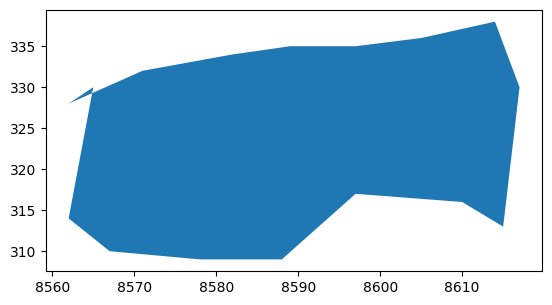

Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
[9331, 0, 10664, 800]
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
[10664, 0, 11997, 800]
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
[11997, 0, 13330, 800]
[13330, 0, 14663, 800]
[14663, 0, 15996, 800]
[0, 800, 1333, 1600]
[1333, 800, 2666, 1600]
[2666, 800, 3999, 1600]
[3999, 800, 5332, 1600]
multipolygon


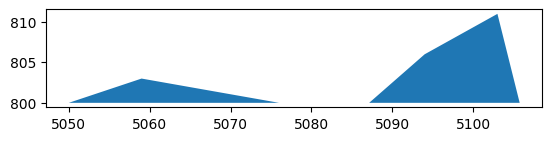

Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
[5332, 800, 6665, 1600]
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
[6665, 800, 7998, 1600]
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon


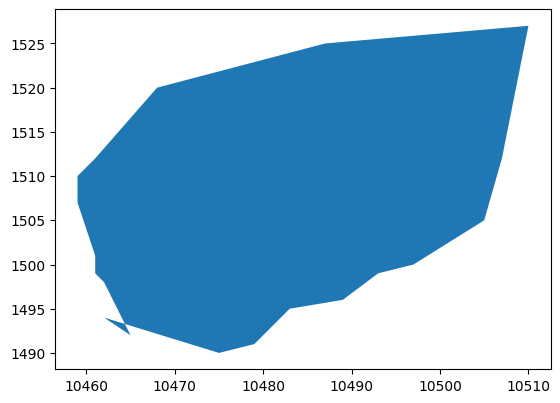

Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
[10664, 800, 11997, 1600]
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
[11997, 800, 13330, 1600]
[13330, 800, 14663, 1600]
[14663, 800, 15996, 1600]
[0, 1600, 1333, 2400]
[1333, 1600, 2666, 2400]
[2666, 1600, 3999, 2400]
[3999, 1600, 5332, 2400]
[5332, 1600, 6665, 2400]
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
[6665, 1600, 7998, 2400]
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polygon
Polyg

In [16]:
# test FUNCTION intersectmask
subtab = annotab[annotab['filename'] == 'CNN2_Keyence_Nbenth_myc_18.jpg']
img=readImage(img_dir,'CNN2_Keyence_Nbenth_myc_18.jpg')
tiles=tileImage(img)

for ind,tile in enumerate(tiles):
    print
    print(tile)
   
    # get the coordinate over the tile image
    xmin=tile[0]
    ymin=tile[1]
    xmax=tile[2]
    ymax=tile[3]
    tilebox = Polygon([(xmin,ymin),(xmax,ymin),(xmax,ymax),(xmin,ymax)])
    
    #create a record for each intersection
    ## the tile record
    record = {}    # empty dictionary
    record["filename"] = 'CNN2_Keyence_Nbenth_myc_18' + '_'+ str(xmin)+"_"+str(ymin)+"_"+str(xmax)+"_"+str(ymax) + '.jpg'
    record["height"] = 800
    record["width"] = 1333
    
    types =[]
    intersect_points = []
    for i in range(0,subtab.shape[0],1):
        anno = json.loads(subtab.iloc[i]["region_shape_attributes"])
        points = convertPoints(anno)
        polygon_points = Polygon(points)
        polygon_points = make_valid(polygon_points)
        
        # create intersection between tile box and annotation
        intersect_anno = polygon_points.intersection(tilebox)
        intersect_points = []
        if not intersect_anno.is_empty: #empty intersections are dropped
            #types.append(intersect_anno.geom_type)
            #print(np.unique(np.array(types)))
            is_polygon = intersect_anno.geom_type=='Polygon'
            is_multipolygon = intersect_anno.geom_type=='MultiPolygon'
            is_mutliothers = intersect_anno.geom_type=='GeometryCollection'
            
            if is_polygon or is_multipolygon or is_mutliothers: # points and lines are dropped
                if is_polygon:
                    print('Polygon')
                    intersect_points = noHolePolygon(intersect_anno)
                else:
                    if is_multipolygon: #remove the small polygons and keep the largest
                        print("multipolygon")
                        polyplot = gpd.GeoSeries([intersect_anno])
                        polyplot.plot()
                        plt.show()
                        #print(new_anno)

In [10]:
# test FUNCTION intersectmask
subtab = annotab[annotab['filename'] == 'CNN2_Keyence_Nbenth_myc_9.jpg']
img=readImage(img_dir,'CNN2_Keyence_Nbenth_myc_9.jpg')
tiles=tileImage(img)

for ind,tile in enumerate(tiles):
    print(tile)
   
    # get the coordinate over the tile image
    xmin=tile[0]
    ymin=tile[1]
    xmax=tile[2]
    ymax=tile[3]
    tilebox = Polygon([(xmin,ymin),(xmax,ymin),(xmax,ymax),(xmin,ymax)])
    
    #create a record for each intersection
    ## the tile record
    record = {}    # empty dictionary
    record["filename"] = 'CNN2_Keyence_Nbenth_myc_9' + '_'+ str(xmin)+"_"+str(ymin)+"_"+str(xmax)+"_"+str(ymax) + '.jpg'
    record["height"] = 800
    record["width"] = 1333
    for i in range(0,subtab.shape[0],1):
        anno = json.loads(subtab.iloc[i]["region_shape_attributes"])
        points = convertPoints(anno)
        polygon_points = Polygon(points)
        polygon_points = make_valid(polygon_points)
        
        # create intersection between tile box and annotation
        intersect_anno = polygon_points.intersection(tilebox)
        intersect_points = []
        if not intersect_anno.is_empty: #empty intersections are dropped
            #print(i)
            is_polygon = intersect_anno.geom_type=='Polygon'
            is_multipolygon = intersect_anno.geom_type=='MultiPolygon'
            is_mutliothers = intersect_anno.geom_type=='GeometryCollection'
            
            
            if is_polygon or is_multipolygon or is_mutliothers: # points and lines are dropped
                
                if is_polygon:
                    #print('Polygon')
                    # convert new annotations from polygons to points
                    exterior = list(intersect_anno.exterior.coords)[:-1] #remove the last point which is the same as the first point
                    interior = list(intersect_anno.interiors)
                
                    if interior != []:
                        # merge interior point/linearring with exterior points
                        interior = GeometryCollection(interior)
                        for geom in interior.geoms: 
                            for i in mapping(geom)['coordinates'][:-1]:
                                exterior.append(i)
                        new_anno = list(exterior)
                        intersect_points = list(new_anno)
                        print(intersect_points)
                    else: # if intersected annotation is polygon without holes
                        intersect_points = list(exterior)
                else:
                    if is_multipolygon: #remove the small polygons and keep the largest
                        #print('MultiPolygon')
                        # keep the largest polygon
                        poly_area = []
                        for geom in intersect_anno.geoms:
                            poly_area.append(geom.area)
                        new_anno = intersect_anno.geoms[poly_area.index(max(poly_area))]
                        new_anno = list(new_anno.exterior.coords)[:-1]
                        intersect_points = list(new_anno)
                        print(intersect_points)
                        
                    else: #is geometrycollection
                        #print('GeometryCollection')
                        # remove linestring
                        for geom in intersect_anno.geoms:
                            if geom.geom_type == 'Point' or geom.geom_type == 'LineString':
                                continue
                            else:
                                new_anno = geom
                        
                        # new_anno should be a polygon with or without holes
                        exterior = list(new_anno.exterior.coords)[:-1] #remove the last point which is the same as the first point
                        interior = list(new_anno.interiors)
                        if interior != []:                        
                            # merge interior point/linearring with exterior points
                            interior = GeometryCollection(interior)

                            for geom in interior.geoms:
                                for i in mapping(geom)['coordinates'][:-1]: #remove duplicated points
                                    exterior.append(i)
                            new_anno = list(exterior)
                            intersect_points = list(new_anno)
                            print(intersect_points)
                        else:
                            new_anno = list(new_anno.exterior.coords)[:-1]
                            intersect_points = list(new_anno)
                            print(intersect_points)
                        transformed_intersect_points = transformPoints(intersect_points)
        #print(intersect_points)    
            #for ind, point in enumerate(new_anno):
                #print(ind, point)
                    #p2=list(p)
                    #p2[0]=p2[0]-xmin
                    #p2[1]=p2[1]-ymin
                    #converted_points.append(p2)
            

        
        

[0, 0, 1333, 800]


NameError: name 'convertPoints' is not defined

In [14]:

def convertPoints(anno):
    '''
    :param anno:
    :paramtype list:
    :param img:
    :paramtype numpy array:
    :param annotab:
    :paramtype pandas dataframe:
    :param files:
    :paramtype list:
    :param classes:
    :paramtype list:
    :return dataset_dicts:
    :rtype list:
    Objective: iterate over each of the segmentations in the image and intersect them with the tile bounding boxes
    '''
    points = []
                    
    for x_coordinate in range(0,len(anno["all_points_x"]),1):
        points.append([anno["all_points_x"][x_coordinate],anno["all_points_y"][x_coordinate]])
    
    # remove empyt lists from the list of points
    points = [x for x in points if x]
    return points

def intersectBoundingBox(points,xmin,ymin,xmax,ymax):
    converted_points = []
    for ind, p in enumerate(points):
        p2=list(p)
        if p[0]>=xmin and p[0]<=xmax and p[1]>=ymin and p[1]<=ymax:
            p2[0]=p[0]-xmin
            p2[1]=p[1]-ymin
            converted_points.append(p2)
    #print(converted_points)
    return converted_points

def transformPoints(points,xmin,ymin,xmax,ymax):
    transformed_points = []
    for ind, p in enumerate(points):
        p2=list(p)
        p2[0]=p[0]-xmin
        p2[1]=p[1]-ymin
        transformed_points.append(p2)
    #print(converted_points)
    return converted_points

def intersectmask(points,xmin,ymin,xmax,ymax):
    '''
    :param points:
    :paramtype list: points forming one mask converted to pair format 
    :param xmin:
    :paramtype int:  left x coordinate of a tile 
    :param xmax:
    :paramtype int:  right x coordinate of a tile 
    :param ymin:
    :paramtype int:  upper y coordinate of a tile 
    :param ymax:
    :paramtype int:  bottom y coordinate of a tile 
    Objective: iterate over each of the segmentations in the image and intersect them with the tile bounding boxes
    '''
    intersect_points_list=[]
    
    # create shapely object for each tile and annotation
    tilebox = Polygon([(xmin,ymin),(xmax,ymin),(xmax,ymax),(xmin,ymax)])
    polygon_anno = Polygon(points)
    polygon_anno = make_valid(polygon_anno) # all annotation should be valid after the make_valid
    # it is ok for an annotation to be multipolygon and geometryCollection
    
    # create intersection between tile box and annotation
    intersect_anno = polygon_anno.intersection(tilebox)
    
    # converting polygon_inters from shapely object to list of points
    if not intersect_anno.is_empty: #empty intersections are dropped
        is_polygon = intersect_anno.geom_type=='Polygon'
        is_polygon_multi = intersect_anno.geom_type=='MultiPolygon'
        is_mutliothers = intersect_anno.geom_type=='GeometryCollection'
        
        if is_polygon or is_multipolygon or is_mutliothers: # points and lines are dropped
            # layout three possible object types of intersected annotation
            if is_polygon: 
                intersect_points_list = noHolePolygon(intersect_anno)
            else: # finished one object type, two more to go
                if is_multipolygon: #if intersection has multipolygons, the smaller polygons are mistakes and should be removed(checked by visualization)
                    poly_area = []
                    for geom in intersect_anno.geoms:
                        poly_area.append(geom.area) # calculate polygon areas
                    new_anno = intersect_anno.geoms[poly_area.index(max(poly_area))]
                    intersect_points_list = list(new_anno.exterior.coords)[:-1]
                #else: #is GeometryCollection
                    #for geom in intersect_anno.geoms:

    return intersect_points_list

def IntersectSegmentations(img_dir,output_dir,tiles,img,annotab,file):
    '''
    :param tiles:
    :paramtype list:
    :param img:
    :paramtype numpy array:
    :param annotab:
    :paramtype pandas dataframe:
    :param files:
    :paramtype list:
    :param classes:
    :paramtype list:
    :return dataset_dicts:
    :rtype list:
    Objective: iterate over each of the segmentations in the image and intersect them with the tile bounding boxes
    '''
    filename=os.path.join(img_dir,file)
    records=[]
    nonvalid_seg_counter=0
    
    # iterate over the tile coordinates
    for ind,tile in enumerate(tiles):
        # get the coordinate over the tile image
        xmin=tile[0]
        ymin=tile[1]
        xmax=tile[2]
        ymax=tile[3]
        # make a tile id using the xmin,ymin,xmax,ymax and the filename
        tile_id = file[:-4] + '_'+ str(xmin)+"_"+str(ymin)+"_"+str(xmax)+"_"+str(ymax)
        # begin building the record by adding the information for the COCO dataset
        record = {} 
        record["filename"] = tile_id + '.jpg'
        record["height"] = 800
        record["width"] = 1300
        # make an empty list of objects for record annotation
        record["annotations"] = []
        subtab = annotab[annotab['filename'] == file]
        objs =[]
        
        for i in range(0,subtab.shape[0],1): #iterate over each annotation belonging to an image
       
            # make a UID for each polygon
            uid = str(uuid.uuid4())

            
            # get the annotation label 
            loadcldict = json.loads(tab_rec['region_attributes'])
            category_id = loadcldict['object']

            # find intersection between an annotation and tiles
            tab_rec = subtab.iloc[anno_i]
            anno = json.loads(tab_rec["region_shape_attributes"]) # get annotation coordinates
            points = convertPoints(anno) # convert coordinates to points in [x,y] format
            
            new_points = intersectmask(points,xmin,ymin,xmax,ymax)
                
            for indp,converted_points in enumerate(converted_points_list):
                if len(converted_points)>0:
                    Sxmin=min(converted_points,key=lambda x:x[0])[0]
                    Symin=min(converted_points,key=lambda x:x[1])[1]
                    Sxmax=max(converted_points,key=lambda x:x[0])[0]
                    Symax=max(converted_points,key=lambda x:x[1])[1]
                    converted_points=[item for sublist in converted_points for item in sublist]
                    Segbbox = [Sxmin,Symin,Sxmax,Symax]
                    obj = {
                        'filename': tile_id + '.jpg',
                        "image_id": tile_id,
                        'structure_id': uid,
                        'height': 512,
                        'width': 512,
                        "category_id": className,
                        "bbox": Segbbox,
                        "segmentation": converted_points,
                        "bbox_mode": 'BoxMode.XYXY_ABS',
                        "iscrowd":0,
                        }
                        #objs.append(obj)
                    record["annotations"].append(obj)
                else:
                    print('2:'+str(ind)+'_'+str(anno_i)+'_'+className)
                    nonvalid_seg_counter=nonvalid_seg_counter+1
        if len(record['annotations']) > 0:
            #subset the image to the tile coordinates
            subimg=img[ymin:ymax,xmin:xmax]
            # write the tile image to the output directory
            cv2.imwrite(os.path.join(output_dir,tile_id+'.jpg'),subimg)
            records.append(record)
    print('nonvalid segmentation: '+str(nonvalid_seg_counter))
    return records

In [35]:
# main code BLOCK 2 
## tiling
for indi,stained_image in enumerate(files): #iterate over each image
    print(stained_image)
    img = readImage(img_dir,stained_image)
    tiles = tileImage(img)
    #print(len(tiles))
    #records = IntersectSegmentations(img_dir,output_dir,tiles,img,annotab,stained_image,classes)
    #dataset_dicts.extend(records)

CNN2_Keyence_Nbenth_myc_8.jpg
40
CNN2_Keyence_Nbenth_myc_19.jpg
72
CNN2_Keyence_Nbenth_myc_18.jpg
72
CNN2_Keyence_Nbenth_myc_9.jpg
40
CNN2_Keyence_Nbenth_myc_33.jpg
80
CNN2_Keyence_Nbenth_myc_31.jpg
60
CNN2_Keyence_Nbenth_myc_29.jpg
60
CNN2_Keyence_Nbenth_myc_22.jpg
80
CNN2_Keyence_Nbenth_myc_21.jpg
72
CNN2_Keyence_Nbenth_myc_20.jpg
72
